In [1054]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymongo as pm
import pprint
from enum import Enum
from datetime import datetime, timedelta
import pytz

In [1057]:

client = pm.MongoClient('bigdatadb.polito.it',                     
                        ssl=True,                     
                        authSource = 'carsharing',                     
                        username = 'ictts',                     
                        password ='Ict4SM22!',                     
                        tlsAllowInvalidCertificates=True) 
db = client['carsharing'] 

#Choose the DB to use 
permenant_booking = db['PermanentBookings']
permenant_parking = db['PermanentParkings']
enjoy_permenant_booking = db['enjoy_PermanentBookings']
enjoy_permenant_parking = db['enjoy_PermanentParkings']

#ENUM of cities
class CITY_ENUM(Enum):
    TO = 'Torino'
    SEA = 'Seattle'
    STU = 'Stuttgart'
class CITY_TIMEZONES(Enum):
    TO = 'Europe/Rome'
    SEA = 'America/Los_Angeles'
    STU = 'Europe/Berlin'

# def get_start_end_unix_zone(timezone):
#     # start_timestamp = datetime(2018, 1, 1,0,0,0,0, pytz.timezone(timezone)).timestamp()
#     # end_timestamp  = datetime(2018, 1, 31,23,59,59,0, pytz.timezone(timezone)).timestamp()
#     return start_timestamp,end_timestamp    

#date starts from 01/01/2018 to 31/01/2018 1514761200 - 1517353200
start_unix_time = datetime.strptime("27/12/2017", "%d/%m/%Y").timestamp()
end_unix_time = datetime.strptime("27/01/2018", "%d/%m/%Y").timestamp()

In [1058]:
#pipeline for getting the data for the rentals with the filteration of the data
#too short and too long rentals are filtered out
#considered if car is moved
def filter_pipeline(city,start_unix_time,end_unix_time):
    return [
    {
        '$match': {
            'city': city,
            'init_time': {
                '$gte': start_unix_time,
                '$lt': end_unix_time
            },
            'final_time': {
                '$gte': start_unix_time,
                '$lt': end_unix_time
            }
        }
    },
    {
        '$project': {
            '_id': 0,
            'duration': {
                '$divide': [
                    { '$subtract': ['$final_time', '$init_time'] },
                    60  # Divide by 60 to convert seconds to minutes
                ]
            },
            'day': {'$dayOfMonth': '$init_date'},
            'hour': {'$hour': '$init_date'},
            'date': {
                '$dateToString': {
                    'format': '%Y-%m-%d',
                    'date': '$init_date'
                }
            },
            'moved': {
                '$ne':[
                    {"$arrayElemAt": [ "$origin_destination.coordinates", 0]},
                    {"$arrayElemAt": [ "$origin_destination.coordinates", 1]}
                 ]
            }
        }
    },
    {
        '$match': {
            'moved': True,
            'duration':{'$gt':5, '$lt':180},
                
        }
    },
    {
        '$group':{
            '_id': {'day': '$day', 'hour': '$hour', 'date': '$date'},
            'total_count': {'$sum': 1},
        }
    },
    {
        '$sort': {
            '_id': 1,
        }
    },
]


### Getting the data from Database

In [1059]:
TO_Data = list(enjoy_permenant_booking.aggregate(filter_pipeline(CITY_ENUM.TO.value,
          start_unix_time,end_unix_time)))
SEA_Data = list(permenant_booking.aggregate(filter_pipeline(CITY_ENUM.SEA.value,
          start_unix_time,end_unix_time)))
STU_Data = list(permenant_booking.aggregate(filter_pipeline(CITY_ENUM.STU.value,
          start_unix_time,end_unix_time)))
cities_data_array = [(CITY_ENUM.TO.value,TO_Data),(CITY_ENUM.SEA.value,SEA_Data),(CITY_ENUM.STU.value,STU_Data)]

#### checking if there are missing records - lwngth must be 744

In [1060]:
print("TO_Data",len(TO_Data))
print("SEA_Data",len(SEA_Data))
print("STU_Data",len(STU_Data))

TO_Data 744
SEA_Data 744
STU_Data 744


##### Dropping the _id col and flattening the data

In [1061]:
def dfModifier(city_list):
  df = pd.DataFrame(city_list, columns =['_id', 'total_count'])
  df['date'] = df['_id'].apply(lambda x: x['date'])
  df['day'] = df['_id'].apply(lambda x: x['day'])
  df['hour'] = df['_id'].apply(lambda x: x['hour'])
  df['myIndex'] = (df['day']-1)*24 + (df['hour']+1)
  df.drop(['_id'], axis=1, inplace=True)
  return df
#day | hour
#1   | 0 -> day*24 + hour => 1*24 + 0 = 24
#1   | 1 -> day*24 + hour => 1*24 + 1 = 25
#1   | 2 -> day*24 + hour => 1*24 + 2 = 26
#day | hour
#0   | 1 -> day*24 + hour => 0*24 + 1 = 1
#0   | 2 -> day*24 + hour => 0*24 + 2 = 2
#0   | 3 -> day*24 + hour => 0*24 + 3 = 3

TO_df = dfModifier(TO_Data)
SEA_df = dfModifier(SEA_Data)
STU_df = dfModifier(STU_Data)
cities_df_array = [(CITY_ENUM.TO.value,TO_df),(CITY_ENUM.SEA.value,SEA_df),(CITY_ENUM.STU.value,STU_df)]


In [1062]:
# calculating the avg for each hour of the day
# Assuming your DataFrame is named TO_df

print("TO_df",TO_df)

TO_hourly_avg = TO_df.groupby('hour')['total_count'].mean().round().reset_index().astype(int)['total_count'].tolist()
SEA_hourly_avg = SEA_df.groupby('hour')['total_count'].mean().round().reset_index().astype(int)['total_count'].tolist()
STU_hourly_avg = STU_df.groupby('hour')['total_count'].mean().round().reset_index().astype(int)['total_count'].tolist()

# print("TO_hourly_avg",TO_hourly_avg)
# print("SEA_hourly_avg",SEA_hourly_avg)
# print("STU_hourly_avg",STU_hourly_avg)


TO_df      total_count        date  day  hour  myIndex
0             66  2018-01-01    1     0        1
1            105  2018-01-01    1     1        2
2            101  2018-01-01    1     2        3
3             80  2018-01-01    1     3        4
4             55  2018-01-01    1     4        5
..           ...         ...  ...   ...      ...
739          118  2017-12-31   31    19      740
740          127  2017-12-31   31    20      741
741           66  2017-12-31   31    21      742
742           43  2017-12-31   31    22      743
743           39  2017-12-31   31    23      744

[744 rows x 5 columns]


In [1063]:
print("TO_hourly_avg",TO_hourly_avg)

TO_hourly_avg [67, 42, 27, 17, 17, 23, 39, 68, 99, 85, 75, 74, 91, 91, 97, 101, 101, 110, 118, 118, 110, 94, 85, 80]


##### finding the mising values and filling them with Mean of Col

In [1064]:
def fillMissingValues(df:pd.DataFrame, avg_df):
  missingValues=set(np.arange(1,31*24+1)).difference(set(df['myIndex']))
  # dfMean = round(np.mean(df['total_count']))
  print("Missing values are:", len(missingValues), missingValues)
  df2 = df
  for value in missingValues:
    dayOfValue = int((value-1)/24)+1
    hourOfValue = (value-1)%24
    new_row = pd.DataFrame({'total_count':avg_df[hourOfValue],'date':f'2018-01-{dayOfValue:02d}',
                            'day':dayOfValue,'hour':hourOfValue,'myIndex':value}, index =[0])
    df2 = pd.concat([new_row,df2.loc[:]]).reset_index(drop = True)
  df2.sort_values(by=['myIndex'], inplace=True)
  return df2

To_FilledValues = fillMissingValues(TO_df, TO_hourly_avg)
SEA_FilledValues = fillMissingValues(SEA_df,SEA_hourly_avg)
STU_FilledValues = fillMissingValues(STU_df,SEA_hourly_avg)
#remember to remove this line - it has never been used !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! TODO
# SEA_FilledValues.at[744,'date'] = '2018-01-31'

Missing values are: 0 set()
Missing values are: 0 set()
Missing values are: 0 set()


In [1065]:
print("To_FilledValues",len(To_FilledValues))
print("SEA_FilledValues",len(SEA_FilledValues))
print("STU_FilledValues",len(STU_FilledValues), STU_FilledValues[743:745])

To_FilledValues 744
SEA_FilledValues 744
STU_FilledValues 744      total_count        date  day  hour  myIndex
743           43  2017-12-31   31    23      744


#### Plotting the data and Rolling mean and std to check if the time series is stationary

In [1066]:
def plotter(plotTitle, df:pd.DataFrame):
    mean = df['total_count'].rolling(window=24*7).mean()
    std = df['total_count'].rolling(window=24*7).std()
    plt.figure(figsize=(14, 6))
    plt.plot(df['myIndex'], mean, label='Rolling Mean', color='red')
    plt.plot(df['myIndex'], std, label='Rolling Std', color='green')
    plt.plot()
    plt.plot(df['myIndex'], df['total_count'], label='Rental', color='blue')
    plt.xlabel('Date')
    plt.ylabel('Total Count')
    plt.legend()
    plt.grid(True)
    plt.title(f'Total Counts in Dates and Hours in - {plotTitle}')
    plt.grid(True)
    plt.savefig(f'{plotTitle}-Roolings-mean-std')
    plt.clf()

In [1067]:
plotter('Torino',To_FilledValues)
plotter('Seattle',SEA_FilledValues)
plotter('Stuttgart',STU_FilledValues)

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [1068]:
cleanFilledCities = [(CITY_ENUM.TO.value,To_FilledValues),(CITY_ENUM.SEA.value,SEA_FilledValues),(CITY_ENUM.STU.value,STU_FilledValues)]

## Computing the ACF and PACF

##### ACF Figure

In [1069]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Use ACF to find q.
# Use PACF to find p.

def ACF_PACF(city_data):
  # plot acf
  plt.figure(figsize=(6,4))
  plot_acf(city_data[1]["total_count"], lags=48)
  plt.title(f'Autocorrelation Function 48 Hours - {city_data[0]}')
  plt.xlabel('Lags')
  plt.grid(True)
  # plt.show()
  plt.savefig(f'{city_data[0]}-ACF')

  # plot pacf
  plt.figure(figsize=(6,4))
  plot_pacf(city_data[1]["total_count"], lags=48)
  plt.title(f'Partial Autocorrelation Function 48 Hours - {city_data[0]}')
  plt.xlabel('Lags')
  plt.grid(True)
  # plt.show()
  plt.savefig(f'{city_data[0]}-PACF')
  


<Figure size 600x400 with 0 Axes>

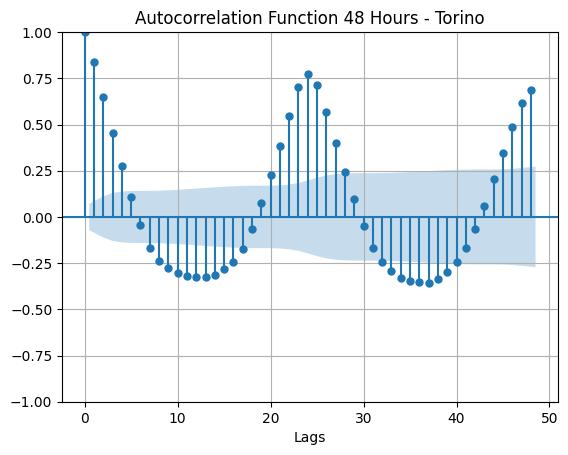

<Figure size 600x400 with 0 Axes>

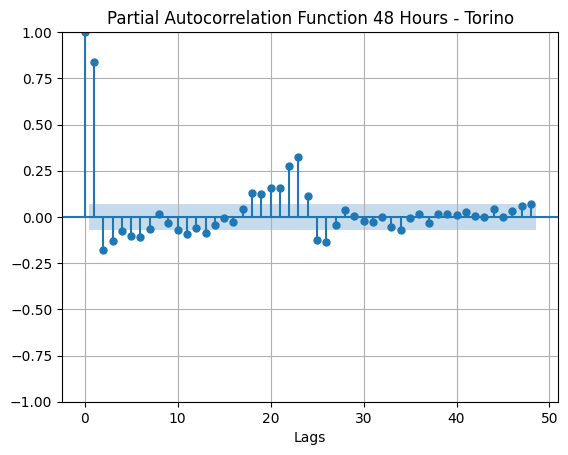

<Figure size 600x400 with 0 Axes>

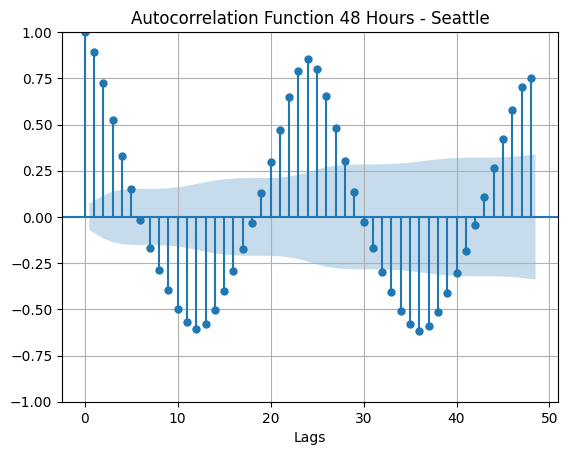

<Figure size 600x400 with 0 Axes>

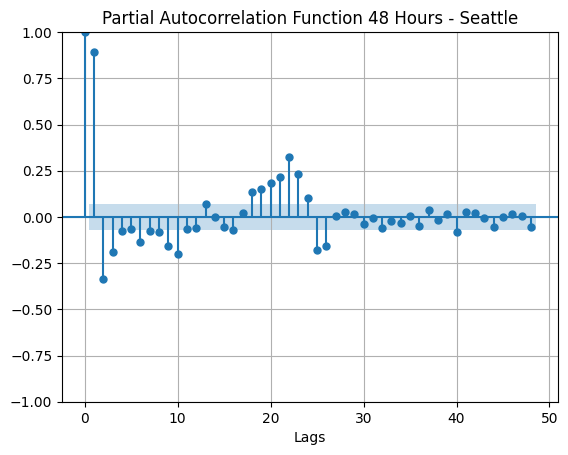

<Figure size 600x400 with 0 Axes>

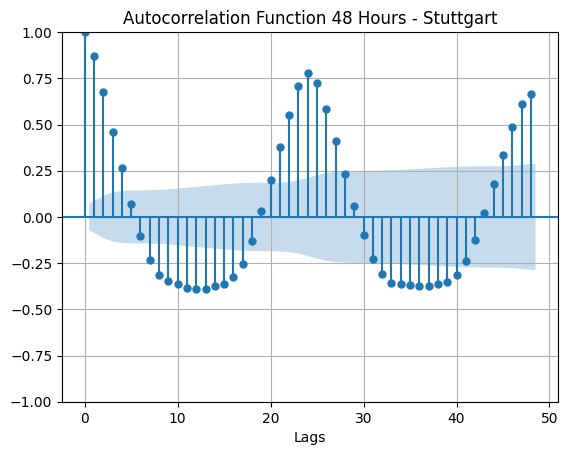

<Figure size 600x400 with 0 Axes>

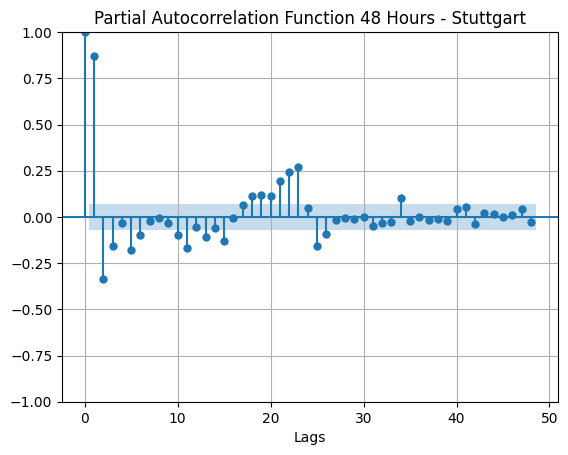

In [1070]:
for city_data in cities_df_array:
  ACF_PACF(city_data)

### ARIMA Model and Prediction

In [1071]:
# for city in cleanFilledCities:
#   print(city[0], len(city[1]))

Torino 744
Seattle 744
Stuttgart 744


In [1085]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

q = 4
p = 2
d = 0
train_size = 24 * 7 * 2 # 24 * 7 * 3 # 3 weeks -> we will change this to 14 days
test_size = 24 * 3 # 10 days -> this takes too long to run so we will use 72 hours
myModel = None
def Predictor(cleanCity):
  originalData = list(cleanCity[1]['total_count'][:train_size])#.tolist()
  y_hat = [None for _ in range(train_size)] # should it be a list or pandas array?
  for record in range(train_size,train_size+test_size):
    model = ARIMA(originalData, order=(p,d,q))
    model_fit = model.fit()
    prediction = int(model_fit.forecast()[0])
    # print(f'Prediction for {cleanCity[0]} at {record} is {prediction}')
    y_hat.append(prediction)
    originalData.append(cleanCity[1]['total_count'][record])
    originalData = originalData[1:]
    myModel = model_fit

  plt.figure(figsize=(15,5))
  plt.title("Predicted values vs Real values")
  plt.plot(list(cleanCity[1]['total_count'][train_size:train_size+test_size]), color='blue', label="Real values")
  plt.plot(list(y_hat[train_size: train_size+test_size]), color='red', label="Predicted values")
  plt.legend()
  plt.xlabel("Lags")
  plt.ylabel("Rentals")
  plt.grid(True)
  plt.savefig(f'2 day prediction {cleanCity[0]}')
  plt.clf()

  # plot residual errors
  residuals = pd.DataFrame(myModel.resid)
  residuals.plot()
  plt.title(f'Residuals - {cleanCity[0]}')
  plt.xlabel("Residual Error")
  plt.ylabel("Residuals")
  plt.grid(True)
  plt.savefig(f'2 day Residuals {cleanCity[0]}')
  plt.clf()

  residuals.plot(kind='kde')
  plt.title(f'Density of Residuals - {cleanCity[0]}')
  plt.xlabel("Residual Error")
  plt.ylabel("Density")
  plt.grid(True)
  plt.savefig(f'2 day Density of Residuals {cleanCity[0]}')
  plt.clf()
  return y_hat, model_fit


In [1086]:
comparisonArray = []
for city_data in cleanFilledCities:
  print(city_data[0])
  y_hat, model_fit = Predictor(city_data)
  y_hat = y_hat[train_size:train_size+test_size]
  comparisonArray.append((city_data[0],city_data[1]['total_count'][train_size:train_size+test_size], y_hat, model_fit))

Torino
Seattle


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Stuttgart


<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [1087]:
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_percentage_error

for item in comparisonArray:
  mse = mean_squared_error(item[1], item[2])
  rmse = np.sqrt(mse)
  r2 = r2_score(item[1], item[2])
  mape = mean_absolute_percentage_error(item[1], item[2])
  print(f'{item[0]} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}, MAPE: {mape:.2f}')

Torino -> MSE: 365.86, RMSE: 19.13, R2: 0.77, MAPE: 0.32
Seattle -> MSE: 373.31, RMSE: 19.32, R2: 0.86, MAPE: 0.38
Stuttgart -> MSE: 526.42, RMSE: 22.94, R2: 0.75, MAPE: 0.43


### Variant values for p d q

In [1088]:
p = [1,2,3,4,5,6]
q = [1,2,3,4]
d = 0
finalValues = []

for cleanCity in cleanFilledCities:
  for i in p:
    for j in q:
      worked = False
      originalData = list(cleanCity[1]['total_count'][:train_size])#.tolist()
      y_hat = [None for _ in range(train_size)] # should it be a list or pandas array?
      for record in range(train_size,train_size+test_size):
        try:
          model = ARIMA(originalData, order=(i,d,j))
          model_fit = model.fit()
          prediction = int(model_fit.forecast()[0])
          # print(f'Prediction for {cleanCity[0]} at {record} is {prediction}')
          y_hat.append(prediction) #shoudl it be int(prediction) or prediction as a float
          originalData.append(cleanCity[1]['total_count'][record])
          originalData = originalData[1:]
          worked = True
        except:
          print("error")
          worked = False
          continue
      if worked:
        actual_values = cleanCity[1]['total_count'][train_size:train_size+test_size]
        prediction_values = y_hat[train_size:train_size+test_size]
        mse = mean_squared_error(actual_values, prediction_values)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual_values, prediction_values)
        mape = mean_absolute_percentage_error(actual_values, prediction_values)
        finalValues.append((cleanCity[0],i,j,mse,rmse,r2,mape))
      elif not worked:
        finalValues.append((cleanCity[0],i,j,0,0,0,0))


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/sta

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/st

error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/st

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [1107]:
from itertools import groupby
import seaborn as sb

# print(finalValues)
dont_touch_this = finalValues
dont = finalValues
touchthis = finalValues

touchThat = pd.DataFrame(touchthis, columns=['city','p','q','mse','rmse','r2','mape'])
#group by city
touchThat = touchThat.groupby('city')

for name, group in touchThat:
    mapeList = group['mape'].tolist()
    mapPD = pd.DataFrame(mapeList)
    MAPE2d = mapPD.values.reshape(6,4)
    print(MAPE2d)
    sb.heatmap(MAPE2d, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5,
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4,5,6])
    
    plt.title(f'MAPE - {name}')
    plt.xlabel("q")
    plt.ylabel("p")
    # plt.show()
    plt.savefig(f'MAPE - {name}')
    plt.clf()

# print(list(group.columns))
# Seattle        [Seattle]
# Stuttgart    [Stuttgart]
# Torino          [Torino]



[[0.4134543  0.4183085  0.41112484 0.41621098]
 [0.34905702 0.36013562 0.36009715 0.37719135]
 [0.36133349 0.35862272 0.32314662 0.36669813]
 [0.38429497 0.         0.34219926 0.34473687]
 [0.35386342 0.         0.3809386  0.35660979]
 [0.33155441 0.         0.36122971 0.36109376]]
[[0.47288956 0.47412135 0.47654009 0.45684104]
 [0.3914207  0.38821646 0.39584282 0.43422034]
 [0.46972115 0.39711275 0.40797186 0.40911027]
 [0.46626101 0.         0.41091194 0.40460801]
 [0.42090013 0.40004203 0.41032641 0.        ]
 [0.40576091 0.40229706 0.40230458 0.41386247]]
[[0.35142608 0.33727385 0.33267761 0.3337484 ]
 [0.27743535 0.27942905 0.2862618  0.31879276]
 [0.27954615 0.27551351 0.30907669 0.28200678]
 [0.30652524 0.         0.2789384  0.30343448]
 [0.28401325 0.         0.31265368 1.18659759]
 [0.28401384 0.28515462 0.         0.        ]]


<Figure size 640x480 with 0 Axes>